# Lab 6: Graphical Models

Welcome to the advanced Machine Learning Course.

The objective of this lab session is to code a few regression algorithms and to apply them to synthetic and real datasets.

Please put **"ML - MDS - TD6"** in the mail subject or I might lose your work (which means 0) and send it to pierre.houdouin@centralesupelec.fr

Please label your notebook **"L6_familyname1_familyname2.ipynb"** or I might lose your work (which means 0).

We begin with the standard imports:

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set_context('poster')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 80, 'linewidths':0}
from tqdm import tqdm
import networkx as nx
import scipy

In [ ]:
class my_GLasso():
    
    def __init__(self, lambd=0.01, nu=0.01, max_iter = 60):
        '''
        Parameters:
        lambd : float
            Penalization parameter selected.
        nu: float>0

        Attributes:
        
        covariance_ : numpy.ndarray, shape (n_features, n_features)
            Estimated covariance matrix.
        precision_ : numpy.ndarray, shape (n_features, n_features)
            Estimated precision matrix (inverse covariance).
        '''
        self.mean = None
        self.covariance_ = None
        self.precision_ = None
        self.lambd = lambd
        self.nu = nu
        self.max_iter = max_iter
    def set_mean(self,X):
        self.mean = np.mean(X, axis=0)
    def set_covariance(self, X):
        n,p = X.shape
        self.covariance =(1/n) * (X - self.mean).T @ (X - self.mean)
        
    
    def set_precision(self):
        return
    
    def fit(self, X):
        """ Fits the GraphicalLasso model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """         
        # TODO

In [ ]:
# TODO : Compare methods of estimating the covariance matrix in low-sample regime
n_samples = 60
n_features = 20

# Simulate data (multivariate gaussian)
from sklearn.datasets import make_sparse_spd_matrix
rng = np.random.RandomState(1)
prec = make_sparse_spd_matrix(n_features, alpha=.98, smallest_coef=.4, largest_coef=.7, random_state=rng)
cov = np.linalg.inv(prec)
mean = np.zeros(n_features)
data = np.random.multivariate_normal(mean, cov, n_samples)
err = np.linalg.norm(prec - prec)

prec_empirical = np.linalg.inv(np.dot(data.T, data) / n_samples)
err_empirical = np.linalg.norm(prec - prec_empirical)

# Scikit-learn Graphical Lasso with cross validation 

# Graphical Lasso estimation using our implementation

# Visual comparison
titles = ["True", "Empirical", "GLASSO (us)", "GLASSO crossval"]
imgs = [prec, prec_empirical, prec_glasso, prec_glassocv]
errors = [err, err_empirical, err_glasso, err_glassocv]

ncols = len(titles)
fig, axes = plt.subplots(1, ncols, figsize=(15, 5))
for idx, ax in enumerate(axes.flatten()):
    img = imgs[idx]
    error = np.around(errors[idx], decimals=2)
    title = titles[idx] + f'\n error {error}'
    ax.imshow(img, vmin=-vmax, vmax=vmax, interpolation='nearest', cmap=plt.cm.RdBu_r)
    ax.set_title(title)
fig.tight_layout()

### Nodewise Regression

Fill in the following class that implements the nodewise regression algorithm to estimate a graphical model structure. You can use `LassoCV` for the regressions. Bonus (not graded): Implement your own cross-validation lasso.

In [13]:
from sklearn.linear_model import LassoCV

class my_nodewise_regression():
    
    def __init__(self, rule='AND', eps=1e-8):
        '''
        Parameters:
        
        rule: {"OR", "AND"}
        
        Attributes:
        
        graph_structure_ : numpy.ndarray, shape (n_features, n_features)
            Estimated adjacancy matrix.        
        '''
        self.graph_structure_ = None
        self.rule = rule
        self.eps = eps
        
    def fit(self, X):
        """ Fit the model to X.
        
        Parameters:
        -----------
        X: (n, p) np.array
            Data matrix
        
        Returns:
        -----
        self
        """         
        #TODO

In [5]:
np.random.seed(1)
n = 5000
p = 6
epsilon=1e-1
X = np.random.randn(n, p)
X.T[1] += X.T[0]
X.T[2] += X.T[1]
real_graph_structure = np.zeros((p, p))
real_graph_structure[0,1] = 1
real_graph_structure[1,0] = 1
real_graph_structure[1,2] = 1
real_graph_structure[2,1] = 1

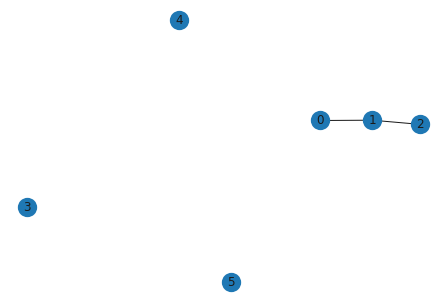

In [6]:
nx_real = nx.from_numpy_matrix(real_graph_structure.T)
nx.draw(nx_real, with_labels=True)

#On dessine la structure initiale

We notice that the initial graph is **poorly connected**, there are a lot of conditional independances between the components.

When we will reconstruct the graph with the predicted value of the precision matrix, **we expect higher values for the conditional correlation between nodes 0, 1 and 2**. 

However, based on what we saw before, we must expect a complete graph if we dont specify a minimum weight for the edges to be taken into account.

In [5]:
#TODO : plot the reconstructed graph with GLASSO using different thresholds. Comment the impact of the choice of the threshold

In [6]:
#TODO : plot the reconstructed graph with nodewise regression using the rule OR

In [7]:
#TODO : plot the reconstructed graph with nodewise regression using the rule OR

## Simulations

Compare the two graph estimators for each of the following models with $p = 300$ and $n = 40, 80, 320$:

- An AR(1)-Block model. In this model the *covariance* matrix is block-diagonal with equalsized AR(1)-blocks of the form $(\Sigma_{Block})_{i, j} = 0.9^{|i−j|}$, take $30 \times 30$ blocks.
- The exponential decay model considered in Fan et al. [2009]. In this model we consider a case where no element of the concentration matrix is exactly zero. The elements of $\Theta$ are given by $\Theta_{ij} = \exp{(−2|i − j|)}$ equals essentially zero when the difference |i − j| is large.

For GLasso estimation, use cross-validation k-fold with loglikelihood loss to select the $\lambda$ penalization parameter. Evaluate your estimation using the Froebenius matrix norm. 

For Node-regression estimation, compare your edge-estimation with the binary (thresholded) covariance matrix. Evaluate your estimation using accuracy and the F1 score. 